In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tvDatafeed import TvDatafeed, Interval

In [2]:
import requests
import json
import pandas as pd
import datetime

In [3]:
n=1

In [4]:
tv = TvDatafeed()
def getdata(name):
    data=tv.get_hist(symbol=name,exchange='BINANCE',interval=Interval.in_daily,n_bars=5000)
    data=data.reset_index()
#     data["datetime"]=data["datetime"]+datetime.timedelta(days=1)
    data["datetime"]=data["datetime"].dt.strftime('%Y-%m-%d')
    data2=data[data["datetime"]>="2020-01-01"].copy()
    data2["datetime"] = pd.to_datetime(data2["datetime"])
    return data2

you are using nologin method, data you access may be limited


In [5]:
def getapi(api):
    response_API=requests.get(api)
    data=response_API.text
    parse_json=json.loads(data)
    df = pd.json_normalize(parse_json['values'])
    listtime=list(df['x'])
    listtime2=[]
    for i in listtime:
        listtime2.append(datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d'))
    df['datetime']=pd.Series(listtime2)
    df["datetime"] = pd.to_datetime(df["datetime"])
#     df["datetime"]=df["datetime"]+datetime.timedelta(days=1)
    df=df[df["datetime"]>="2020-01-01"].copy()
    df=df.drop(columns=['x'])
    df.rename(columns={'y':'value'},inplace=True)
    df=df.drop_duplicates(subset=['datetime'])
    return df

In [6]:
bitcoi=getdata('BTCUSDT')
eth=getdata('ETHUSDT')
bnb=getdata('BNBUSDT')
ada=getdata('ADAUSDT')
bitcoi=bitcoi[["datetime","volume","open","high","low","close"]]
bitcoi.tail(5)

,datetime,volume,open,high,low,close
1640,2022-02-11,26556.85681,42373.73,43079.49,41688.88,42217.87
1641,2022-02-12,17648.58975,42217.87,42760.00,41870.00,42053.66
1642,2022-02-13,34010.13060,42053.65,42842.40,41550.56,42535.94
1643,2022-02-14,38093.46331,42535.94,44751.40,42427.03,44544.86
1644,2022-02-15,2510.94095,44544.85,44549.97,43945.32,43987.14


In [7]:
number_transactions=getapi('https://api.blockchain.info/charts/n-transactions?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
number_address=getapi('https://api.blockchain.info/charts/n-unique-addresses?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=getapi('https://api.blockchain.info/charts/transactions-per-second?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=transaction_second.groupby(['datetime']).mean().reset_index()
total_bitcoin=getapi('https://api.blockchain.info/charts/total-bitcoins?timespan=4years&rollingAverage=24hours&format=json&sampled=true')
volume_trade=getapi('https://api.blockchain.info/charts/trade-volume?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
hash_rate=getapi('https://api.blockchain.info/charts/hash-rate?timespan=4years&rollingAverage=24hours&format=json&sampled=false')

In [8]:
bitcoin=bitcoi.merge(eth[["datetime","close"]],on='datetime',how='left',suffixes=('_bitcoin', '_eth'))
bitcoin=bitcoin.merge(bnb[["datetime","close"]],on='datetime',how='left')
bitcoin=bitcoin.merge(ada[["datetime","close"]],on='datetime',how='left',suffixes=('_bnb', '_ada'))

In [9]:
data_api=number_transactions.merge(number_address,on='datetime',how='left',suffixes=('_number_transaction', '_number_address'))
data_api=data_api.merge(transaction_second,on='datetime',how='left')
data_api=data_api.merge(total_bitcoin,on='datetime',how='left',suffixes=('_transaction_second', '_total_bitcoin'))
data_api=data_api.merge(volume_trade,on='datetime',how='left')
data_api=data_api.merge(hash_rate,on='datetime',how='left',suffixes=('_volume_trade', '_hash_rate'))


In [10]:
bitcoin=bitcoin.merge(data_api,on='datetime',how='left')
bitcoin.tail(5)

,datetime,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate
772,2022-02-11,26556.85681,42373.73,43079.49,41688.88,42217.87,2918.88,403.6,1.059,228189.0,604018.0,3.068403,1.895464e+07,3.225592e+08,2.481103e+08
773,2022-02-12,17648.58975,42217.87,42760.00,41870.00,42053.66,2871.13,397.9,1.042,208977.0,590527.0,2.986458,1.895553e+07,1.404551e+08,2.096333e+08
774,2022-02-13,34010.13060,42053.65,42842.40,41550.56,42535.94,2929.75,403.4,1.049,247592.0,630477.0,2.536632,1.895642e+07,9.067330e+07,2.029994e+08
775,2022-02-14,38093.46331,42535.94,44751.40,42427.03,44544.86,3183.52,432.4,1.107,273623.0,680501.0,2.481250,1.895731e+07,1.878267e+08,2.321888e+08
776,2022-02-15,2510.94095,44544.85,44549.97,43945.32,43987.14,3139.56,432.5,1.098,NaN,NaN,NaN,NaN,NaN,NaN


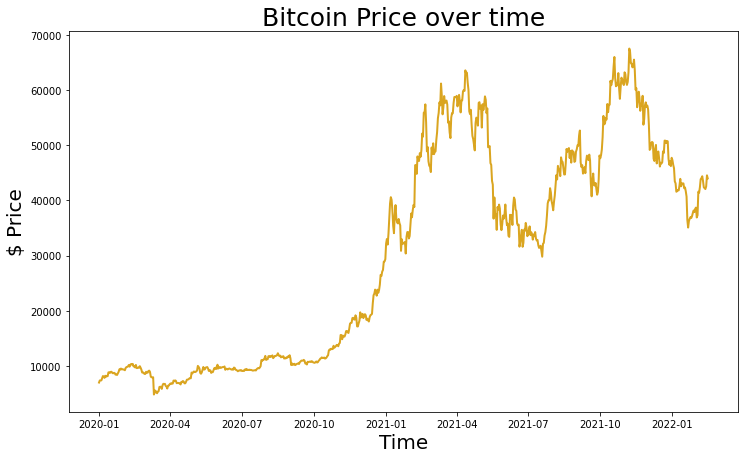

In [11]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["close_bitcoin"], color='goldenrod', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)
plt.show()

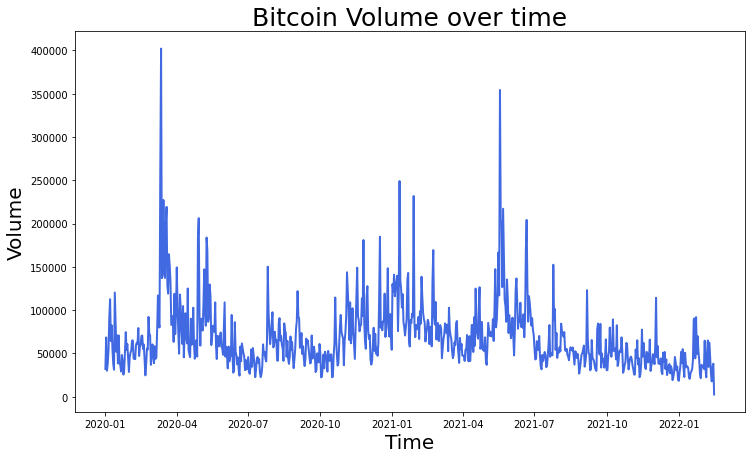

In [12]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["volume"], color='royalblue', lw=2)
plt.title("Bitcoin Volume over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Volume", size=20);

In [13]:
bitcoin.isnull().sum()

datetime                     0
volume                       0
open                         0
high                         0
low                          0
close_bitcoin                0
close_eth                    0
close_bnb                    0
close_ada                    0
value_number_transaction     1
value_number_address         3
value_transaction_second     1
value_total_bitcoin         32
value_volume_trade           1
value_hash_rate              1
dtype: int64

In [14]:
# bitcoin=bitcoin.interpolate(method='linear')
temp=bitcoin["datetime"]
bitcoin=bitcoin.drop(columns=['datetime'])
bitcoin=bitcoin.interpolate()
bitcoin['datetime']=temp
bitcoin.isnull().sum()

volume                      0
open                        0
high                        0
low                         0
close_bitcoin               0
close_eth                   0
close_bnb                   0
close_ada                   0
value_number_transaction    0
value_number_address        0
value_transaction_second    0
value_total_bitcoin         0
value_volume_trade          0
value_hash_rate             0
datetime                    0
dtype: int64

In [15]:
required_features = ['volume','open', 'high', 'low','close_eth','close_bnb','close_ada','value_number_transaction','value_number_address','value_transaction_second','value_total_bitcoin','value_volume_trade', 'value_hash_rate']
output_label = 'close_bitcoin'

In [16]:
x_train, x_test, y_train, y_test = train_test_split(bitcoin[required_features],bitcoin[output_label],test_size = 0.2)

In [17]:
x_test

,volume,open,high,low,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate
716,25020.052710,46133.83,47392.37,45500.00,3959.93,533.9000,1.24200,239170.0,616818.0,3.169965,1.890307e+07,3.563099e+08,1.539525e+08
261,38440.036858,10933.40,11179.79,10887.37,385.25,27.2035,0.09141,296357.0,624125.0,3.971007,1.849269e+07,8.826939e+07,1.284789e+08
369,116049.997038,31989.75,34360.00,29900.00,1099.56,41.8219,0.25873,354091.0,845343.0,3.958681,1.858984e+07,1.432013e+09,1.451608e+08
276,23212.001595,10542.07,10696.87,10517.87,352.37,28.9668,0.09686,268019.0,562147.0,3.620139,1.850694e+07,3.147720e+07,1.515921e+08
196,43375.571191,9197.60,9226.15,9047.25,233.57,17.1647,0.12602,345849.0,709099.0,3.851042,1.843308e+07,8.339369e+07,1.172690e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,48797.749502,11505.13,11541.15,11200.00,365.50,30.0516,0.10414,324647.0,712317.0,3.703993,1.851764e+07,1.118547e+08,1.486935e+08
126,147154.611378,9143.40,10067.00,9021.00,212.00,17.0003,0.05123,341986.0,696092.0,3.697569,1.836456e+07,2.861557e+08,1.176844e+08
691,49917.850170,56243.83,58009.99,55317.00,4339.44,591.1000,1.75100,283401.0,700954.0,2.626910,1.887998e+07,4.947626e+08,1.487822e+08
284,52825.283710,11369.02,11720.01,11172.00,386.51,30.6503,0.10945,314174.0,658073.0,3.163194,1.851408e+07,6.021583e+07,1.429377e+08


In [18]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [19]:
model.score(x_test, y_test)

0.9987121273167054

In [20]:
future_set = bitcoin.tail(n).copy()
future_set

,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate,datetime
776,2510.94095,44544.85,44549.97,43945.32,43987.14,3139.56,432.5,1.098,273623.0,680501.0,2.48125,18957306.25,1.878267e+08,2.321888e+08,2022-02-15


In [21]:
prediction = model.predict(future_set[required_features])
prediction

array([43950.62924157])

In [22]:
today = datetime.date.today()
tomorrow = future_set["datetime"].iloc[0] + datetime.timedelta(days=1)
tmr = tomorrow.strftime("%B %d, %Y")
print("The prediction of bitcoin price on",tmr,"at 7 P.M. is",prediction[0])

The prediction of bitcoin price on February 16, 2022 at 7 P.M. is 43950.62924157205
